In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import haversine as hs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
!pip install haversine


Defaulting to user installation because normal site-packages is not writeable


In [5]:
df = pd.read_csv('./uber.csv')

In [6]:
df.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [8]:
df = df.drop(['Unnamed: 0', 'key'], axis = 1)

In [9]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [10]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime,
                                    errors='coerce')

In [11]:
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [12]:
df= df.assign(hour = df.pickup_datetime.dt.hour,
              day= df.pickup_datetime.dt.day,
              month = df.pickup_datetime.dt.month,
              year = df.pickup_datetime.dt.year,
              dayofweek = df.pickup_datetime.dt.dayofweek)

In [13]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3


In [14]:
df = df.drop('pickup_datetime',axis=1)
df.dtypes

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
hour                   int32
day                    int32
month                  int32
year                   int32
dayofweek              int32
dtype: object

fare_amount             Axes(0.125,0.786098;0.352273x0.0939024)
pickup_longitude     Axes(0.547727,0.786098;0.352273x0.0939024)
pickup_latitude         Axes(0.125,0.673415;0.352273x0.0939024)
dropoff_longitude    Axes(0.547727,0.673415;0.352273x0.0939024)
dropoff_latitude        Axes(0.125,0.560732;0.352273x0.0939024)
passenger_count      Axes(0.547727,0.560732;0.352273x0.0939024)
hour                    Axes(0.125,0.448049;0.352273x0.0939024)
day                  Axes(0.547727,0.448049;0.352273x0.0939024)
month                   Axes(0.125,0.335366;0.352273x0.0939024)
year                 Axes(0.547727,0.335366;0.352273x0.0939024)
dayofweek               Axes(0.125,0.222683;0.352273x0.0939024)
dtype: object

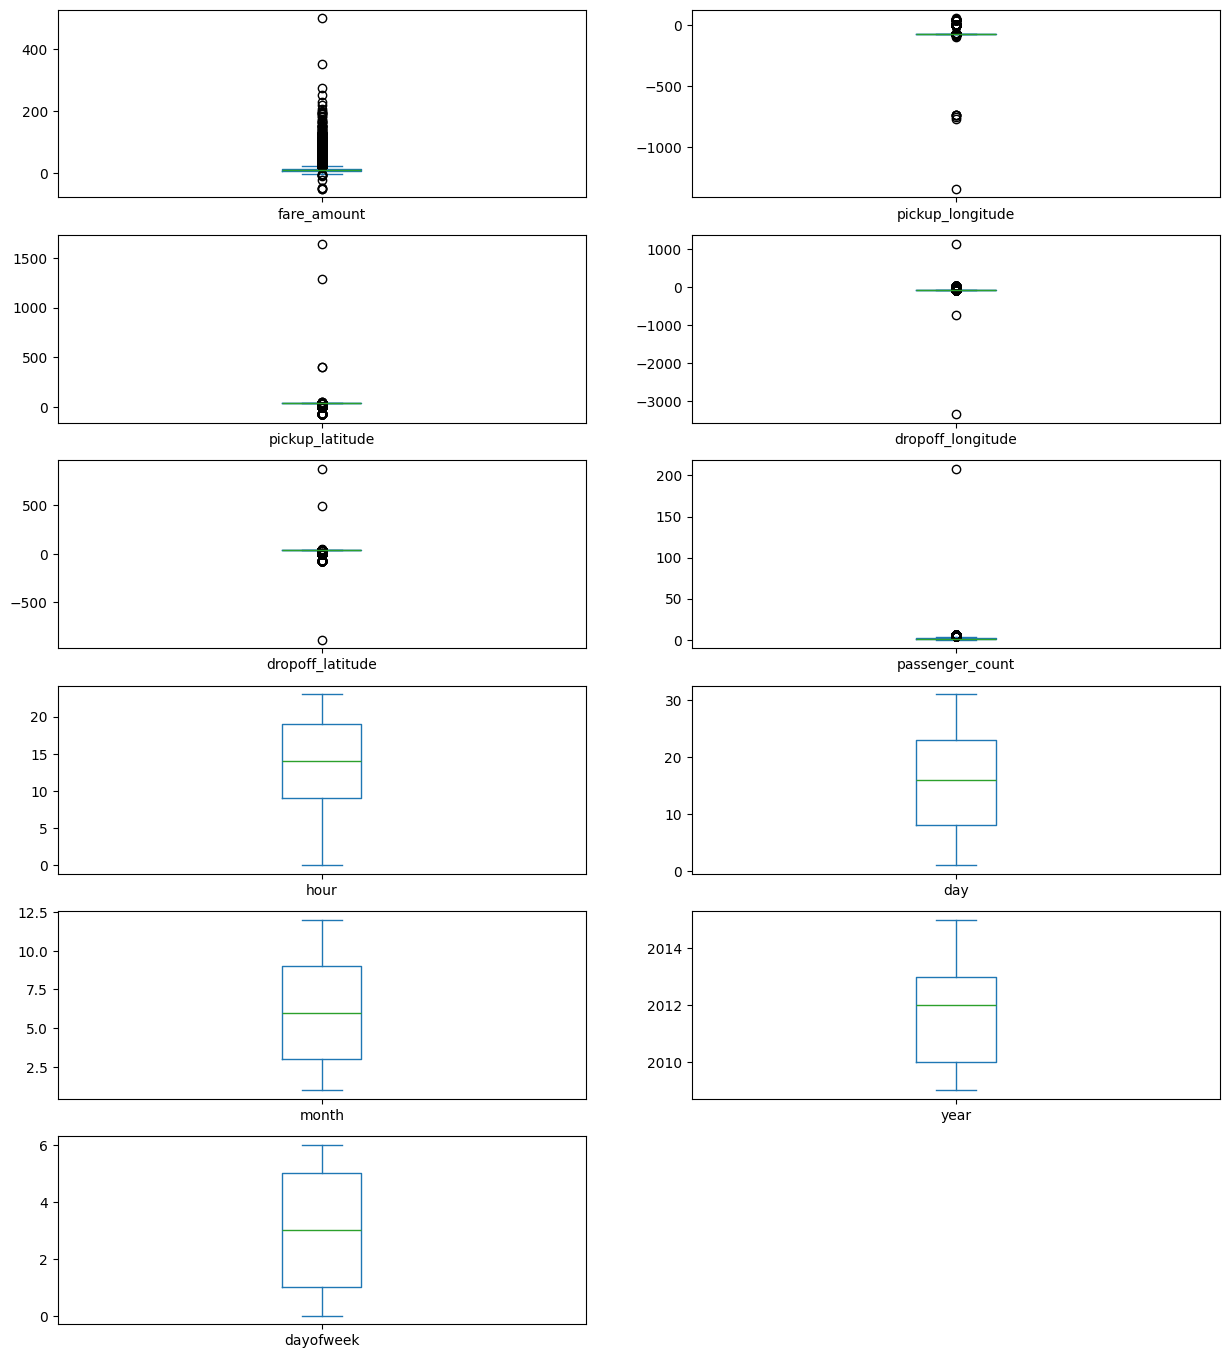

In [15]:
df.plot(kind = "box",subplots = True,layout = (7,2),
        figsize=(15,20))

In [16]:
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1

def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(df , c)
    return df1

In [17]:
df = treat_outliers_all(df , df.iloc[: , 0::])

In [18]:
travel_dist = []
for pos in range(len(df['pickup_longitude'])):
    long1,lati1,long2,lati2 = [df['pickup_longitude'][pos],
                               df['pickup_latitude'][pos],
                               df['dropoff_longitude'][pos],
                               df['dropoff_latitude'][pos]]
    loc1=(lati1,long1)
    loc2=(lati2,long2)
    c = hs.haversine(loc1,loc2)
    travel_dist.append(c)
print(travel_dist)
df['dist_travel_km'] = travel_dist
df.head()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683325
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457593
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036384
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661686
4,16.0,-73.929786,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.116088


In [19]:
df= df.loc[(df.dist_travel_km >= 1) | (df.dist_travel_km <= 130)]
print('Observations left in the dataset:', df.shape)

Observations left in the dataset: (199999, 12)


In [20]:
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |
                               (df.pickup_latitude < -90) |
                               (df.dropoff_latitude > 90) |
                               (df.dropoff_latitude < -90) |
                               (df.pickup_longitude > 180) |
                               (df.pickup_longitude < -180) |
                               (df.dropoff_longitude > 90) |
                               (df.dropoff_longitude < -90)]

In [21]:
df.drop(incorrect_coordinates, inplace = True,
        errors = 'ignore')

C:\Users\Sumeet\AppData\Local\Temp\ipykernel_12440\1102255182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(incorrect_coordinates, inplace = True,


In [22]:
corr = df.corr()
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
fare_amount,1.000000,0.154056,-0.110856,0.218681,-0.125874,0.015798,-0.023605,0.004552,0.030815,0.141271,0.013664,0.786381
pickup_longitude,0.154056,1.000000,0.259492,0.425622,0.073309,-0.013202,0.011590,-0.003194,0.001168,0.010193,-0.024645,0.048423
pickup_latitude,-0.110856,0.259492,1.000000,0.048889,0.515736,-0.012879,0.029691,-0.001544,0.001561,-0.014247,-0.042304,-0.073385
dropoff_longitude,0.218681,0.425622,0.048889,1.000000,0.245670,-0.009304,-0.046560,-0.004008,0.002392,0.011347,-0.003337,0.155200
dropoff_latitude,-0.125874,0.073309,0.515736,0.245670,1.000000,-0.006329,0.019765,-0.003498,-0.001191,-0.009595,-0.031932,-0.052657
passenger_count,0.015798,-0.013202,-0.012879,-0.009304,-0.006329,1.000000,0.020260,0.002699,0.010353,-0.009743,0.048542,0.009916
hour,-0.023605,0.011590,0.029691,-0.046560,0.019765,0.020260,1.000000,0.004664,-0.003924,0.002162,-0.086956,-0.035679
day,0.004552,-0.003194,-0.001544,-0.004008,-0.003498,0.002699,0.004664,1.000000,-0.017358,-0.012165,0.005609,0.001738
month,0.030815,0.001168,0.001561,0.002392,-0.001191,0.010353,-0.003924,-0.017358,1.000000,-0.115860,-0.008785,0.010046
year,0.141271,0.010193,-0.014247,0.011347,-0.009595,-0.009743,0.002162,-0.012165,-0.115860,1.000000,0.006116,0.022282


<Axes: >

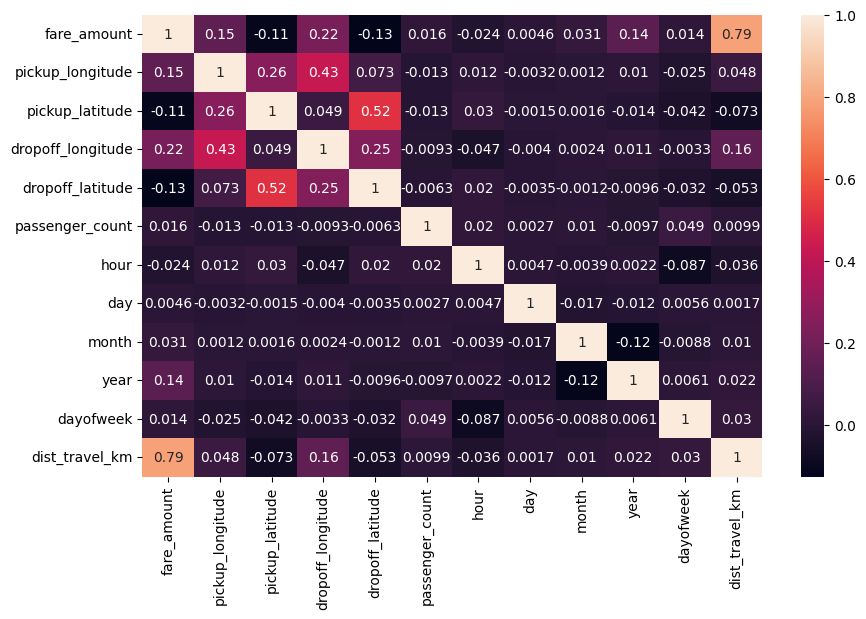

In [23]:
fig,axis = plt.subplots(figsize = (10,6))
sns.heatmap(df.corr(),annot = True)

In [24]:
x = df[['pickup_longitude','pickup_latitude','dropoff_longitude',
        'dropoff_latitude','passenger_count','hour','day','month',
        'year', 'dayofweek', 'dist_travel_km']]
y = df['fare_amount']

In [25]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.33)
regression = LinearRegression()
regression.fit(x_train,y_train)

LinearRegression()

In [26]:
prediction = regression.predict(x_test)
print('Prediction for x:\n', prediction,'\n')
print('Fare Amount test data:\n', y_test)

Prediction for x:
 [ 9.12778643 11.91442356 13.18396299 ...  7.63340788 14.9572131
  8.83392458] 

Fare Amount test data:
 89982      6.10
37081      9.70
99437     18.50
57482     15.00
113623    22.25
          ...  
186342    12.50
168193    14.00
48316      5.30
83999     11.50
195355     7.50
Name: fare_amount, Length: 66000, dtype: float64


In [27]:
print('R2 Score:\n',r2_score(y_test, prediction))

R2 Score:
 0.6618336458553864


In [28]:
MSE = mean_squared_error(y_test, prediction)
print('Mean Squared Error:\n', MSE)

Mean Squared Error:
 10.001721025047418


In [29]:
RMSE = np.sqrt(MSE)
print('Root Mean Squared Error:\n', RMSE)

Root Mean Squared Error:
 3.1625497664143434


In [30]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestRegressor()

In [31]:
y_pred = rf.predict(x_test)
print('Predictions for Fare Amount:\n', y_pred)

Predictions for Fare Amount:
 [ 7.032  10.651  13.0195 ...  6.69   12.295   7.62  ]


In [32]:
R2_Random = r2_score(y_test, y_pred)
print('Random R2 Score:\n', R2_Random)

Random R2 Score:
 0.7932196723983119


In [33]:
MSE_Random = mean_squared_error(y_test, y_pred)
print('Random Mean Squared Error:\n', MSE_Random)

Random Mean Squared Error:
 6.115804026013681


In [34]:
RMSE_Random = np.sqrt(mean_squared_error(y_test, y_pred))
print('Random Root Mean Squared Error:\n', RMSE_Random)

Random Root Mean Squared Error:
 2.473015168981719
